In [25]:
import fairseq
import torch
import os
import glob
from fairseq.models.wav2vec import Wav2VecModel
from fairseq.models.roberta import RobertaModel
import tqdm
import librosa
import math

**Audio Model**

In [26]:
vq_model_path = '/dfs/user/prabhat8/CS224S/models/vq-wav2vec_kmeans.pt'
data_path = '/dfs/user/prabhat8/CS224S/gad'

In [ ]:
cp = torch.load(vq_model_path)
model = Wav2VecModel.build_model(cp['args'], task=None)
model.load_state_dict(cp['model'])
model.eval()

roberta = RobertaModel.from_pretrained('/dfs/user/prabhat8/CS224S/models/', checkpoint_file='bert_kmeans.pt')
roberta.eval()


In [38]:
def indices_to_string(idxs): 
        # based on fairseq/examples/wav2vec/vq-wav2vec_featurize.py
        return "<s>"+" " +" ".join("-".join(map(str, a.tolist())) for a in idxs.squeeze(0))

In [46]:
import pickle
with torch.no_grad():
    for wav in tqdm.tqdm(glob.glob(f"{data_path}/*.wav")):
        fname = os.path.basename(wav)[:-4] + "_tokens.txt"
        fname_p = os.path.basename(wav)[:-4] + "_tokens.p"
        audio_input, sr = librosa.load(wav, sr=16000, res_type='kaiser_fast')
        try:
            wav_input_16khz = torch.tensor(audio_input).unsqueeze(0)
#             print(wav_input_16khz.shape)
            if len(audio_input) > 16000*60:
                vals = torch.chunk(wav_input_16khz, round(len(audio_input) / (16000*60)), dim=-1)
#                 if len(vals) > 1:
#                     print(len(vals), len(audio_input) / (16000*60))
            else:
                vals = [wav_input_16khz]
            z = []
            for val in vals:
                zi = model.feature_extractor(val)
                z.append(zi.squeeze())
            z = torch.cat(z, dim=-1).unsqueeze(0)
            _, idxs = model.vector_quantizer.forward_idx(z)
            idx_str = indices_to_string(idxs)
            tokens = roberta.task.source_dictionary.encode_line(idx_str, append_eos=True, add_if_not_exist=False).cpu().detach().numpy()
            pickle.dump(tokens, open(os.path.join(data_path, 'vqwav2vec_tokens', fname_p), 'wb') )
            with open(os.path.join(data_path, 'vqwav2vec_tokens', fname), 'w') as f:
                for item in tokens:
                    f.write(str(item)+'\t')
                    
        except Exception as e:
            print(e, wav, len(audio_input))
# x = model(wav_input_16khz)
# x

100%|██████████| 2257/2257 [6:06:16<00:00,  9.74s/it]  


In [66]:
with torch.no_grad():
    for wav_tok_file in tqdm.tqdm(glob.glob(f"{data_path}/vqwav2vec_tokens/*.p")):
        fname_f = os.path.basename(wav_tok_file)[:-9] + "_feat.p"
        wav_tokens = pickle.load( open( wav_tok_file, "rb" ) )
        wav_tokens_inp = torch.Tensor(wav_tokens)[:2048].type(torch.LongTensor)
        feats = roberta.extract_features(wav_tokens_inp)
        pickle.dump(feats, open(os.path.join(data_path, 'vqwav2vec_features', fname_f), 'wb') )

100%|██████████| 2257/2257 [35:30<00:00,  1.06it/s]


**Text Model**

In [ ]:
roberta_model_path = '/dfs/user/prabhat8/CS224S/models/roberta.large'
roberta = RobertaModel.from_pretrained(roberta_model_path, checkpoint_file='model.pt')
roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
import pickle
with torch.no_grad():
    for transcript_file in tqdm.tqdm(glob.glob(f"{data_path}/transcripts/*.txt")):
        fname_feat = os.path.basename(transcript_file)[:-4] + "_feat.p"
        fname_tok = os.path.basename(transcript_file)[:-4] + "_tokens.p"
        with open(transcript_file) as f:
            text = f.readlines()
            if type(text) == list:
                if text:
                    text = text[0]
                else:
                    text = ""
        tokens = roberta.encode(text)[:512]
        pickle.dump(tokens, open(os.path.join(data_path, 'transcripts_tokens', fname_tok), 'wb') )
        last_layer_features = roberta.extract_features(tokens)
#         print(last_layer_features.shape)
        pickle.dump(last_layer_features, open(os.path.join(data_path, 'transcripts_features', fname_feat), 'wb') )
        

**Combined model**

In [93]:
audio_feat = {}
text_feat = {}
with torch.no_grad():
    for audio_feat_file in tqdm.tqdm(glob.glob(f"{data_path}/vqwav2vec_features/*.p")):
        fname = os.path.basename(audio_feat_file)[:-7] + ".wav"
        ft = pickle.load( open( audio_feat_file, "rb" ) )
        audio_feat[fname] = ft[0][0] #CLS
    for text_feat_file in tqdm.tqdm(glob.glob(f"{data_path}/transcripts_features/*.p")):
        fname = os.path.basename(text_feat_file)[:-7] + ".wav"
        ft = pickle.load( open( text_feat_file, "rb" ) )
        text_feat[fname] = ft[0][0] #CLS

100%|██████████| 2257/2257 [00:03<00:00, 644.12it/s]


In [94]:
combined_feat = {}
for key,val in audio_feat.items():
    ft = torch.cat((val, text_feat[key]))
    combined_feat[key] = ft

In [95]:
import pandas as pd
labels = pd.read_csv(os.path.join(data_path, 'data.csv'))
labels = labels.drop_duplicates('filename').set_index('filename')

labels['feats_audio'] = labels.index.map(lambda x: audio_feat[x])
labels['feats_text'] = labels.index.map(lambda x: text_feat[x])
labels['feats_combi'] = labels.index.map(lambda x: combined_feat[x])
labels['anxiety'] = labels['bucketed_score'] > 0

In [96]:
labels['feats_combi'].iloc[0].shape

torch.Size([1792])

In [99]:
import numpy as np
feats, y = np.stack(labels.feats_combi.values), labels['anxiety']
feats.shape, y.shape

((2257, 1792), (2257,))

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [101]:
train_idx, test_idx = train_test_split(np.arange(len(feats)), test_size=0.15, random_state=24)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.15, random_state=24)

In [102]:
split = [""]*len(feats)
for i in train_idx:
    split[i] = 'train'
for i in valid_idx:
    split[i] = 'valid'
for i in test_idx:
    split[i] = 'test'
    
labels['split'] = split
labels.split.value_counts()

train    1630
test      339
valid     288
Name: split, dtype: int64

In [103]:
labels.columns

Index(['dataset', 'user', 'score', 'bucketed_score', 'duration', 'feats_audio',
       'feats_text', 'feats_combi', 'anxiety', 'split'],
      dtype='object')

In [104]:
labels[['dataset', 'user', 'score', 'bucketed_score', 'duration', 'anxiety', 'split']].to_pickle(os.path.join(data_path, 'data_split_vqwav2vec.pkl'))

In [105]:
X_train, y_train = np.stack(labels[labels.split == 'train'].feats_combi.values), labels[labels.split == 'train']['anxiety']
X_valid, y_valid = np.stack(labels[labels.split == 'valid'].feats_combi.values), labels[labels.split == 'valid']['anxiety']
X_test, y_test = np.stack(labels[labels.split == 'test'].feats_combi.values), labels[labels.split == 'test']['anxiety']

In [106]:
print(len(X_train), len(X_valid), len(X_test))

1630 288 339


In [107]:
from sklearn.metrics import roc_auc_score
def analyze_clf(clf, y_prob=None):
    if y_prob is None:
        clf = clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_valid)
        if not hasattr(clf, 'predict_proba'):
            y_prob = clf.decision_function(X_valid)
        else:
            y_prob = clf.predict_proba(X_valid)[:, 1]
    else:
        y_pred = y_prob > 0.5
    print(y_pred.shape)
    from sklearn.metrics import confusion_matrix,  classification_report
    y_true = y_valid
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print(roc_auc_score(y_true=y_true, y_score=y_prob))

In [108]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
analyze_clf(dummy_clf)


(288,)
[[78 71]
 [76 63]]
              precision    recall  f1-score   support

       False       0.51      0.52      0.51       149
        True       0.47      0.45      0.46       139

    accuracy                           0.49       288
   macro avg       0.49      0.49      0.49       288
weighted avg       0.49      0.49      0.49       288

0.5


In [109]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=300, penalty='l1', solver='liblinear'))
analyze_clf(clf)

(288,)
[[89 60]
 [57 82]]
              precision    recall  f1-score   support

       False       0.61      0.60      0.60       149
        True       0.58      0.59      0.58       139

    accuracy                           0.59       288
   macro avg       0.59      0.59      0.59       288
weighted avg       0.59      0.59      0.59       288

0.6356525517840761


In [133]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, max_iter=1500))
analyze_clf(clf)

(288,)
[[89 60]
 [52 87]]
              precision    recall  f1-score   support

       False       0.63      0.60      0.61       149
        True       0.59      0.63      0.61       139

    accuracy                           0.61       288
   macro avg       0.61      0.61      0.61       288
weighted avg       0.61      0.61      0.61       288

0.6440056008884167


In [126]:
clf = make_pipeline(StandardScaler(), SVC(C=10))
analyze_clf(clf)

(288,)
[[95 54]
 [55 84]]
              precision    recall  f1-score   support

       False       0.63      0.64      0.64       149
        True       0.61      0.60      0.61       139

    accuracy                           0.62       288
   macro avg       0.62      0.62      0.62       288
weighted avg       0.62      0.62      0.62       288

0.679059437014147


In [135]:
from sklearn.metrics import confusion_matrix,  classification_report
clf = make_pipeline(StandardScaler(), SVC(C=10))
clf.fit(np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]))
y_true = y_test
y_pred = clf.predict(X_test)
y_prob = clf.decision_function(X_test)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(roc_auc_score(y_true=y_true, y_score=y_prob))

[[120  53]
 [ 80  86]]
              precision    recall  f1-score   support

       False       0.60      0.69      0.64       173
        True       0.62      0.52      0.56       166

    accuracy                           0.61       339
   macro avg       0.61      0.61      0.60       339
weighted avg       0.61      0.61      0.60       339

0.6647050630266731


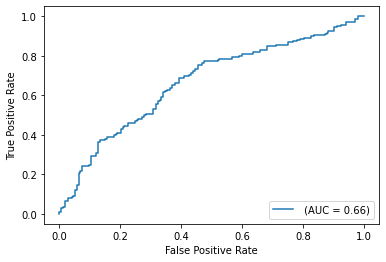

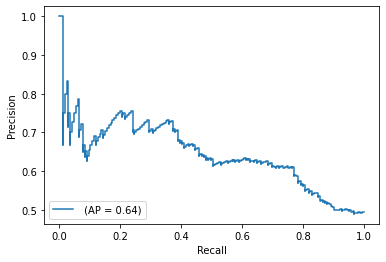

In [130]:
import matplotlib.pyplot as plt
import IPython
from sklearn import datasets, metrics, model_selection, svm
metrics.plot_roc_curve(clf, X_test, y_test, pos_label=None, name='')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_curve.pdf')
metrics.plot_precision_recall_curve(clf, X_test, y_test, pos_label=None, name='')  
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('prc_curve.pdf')